In [257]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Load Data

In [2]:
from urllib.request import HTTPError

def load_turnstile_data(urls):
    dfs = []
    for url in urls:
        try:
            df = pd.read_csv(url)
            dfs.append(df)
        except HTTPError as err:
            if err.code == 404:
                continue
            else:
                raise err
    return pd.concat(dfs)

def format_day_month(num):
    return '0' + str(num) if num < 10 else str(num)

def format_year(num):
    return str(num)[-2:]

def generate_url(date):
    y = format_year(date.year)
    m = format_day_month(date.month)
    d = format_day_month(date.day)
    return f'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{y}{m}{d}.txt'

def fetch_data_for_date_range(start, end):
    urls = list(map(generate_url, pd.date_range(start, end, freq="D")))
    return load_turnstile_data(urls)


In [4]:
mta_data = fetch_data_for_date_range('3/1/2019', '4/01/2019')

In [5]:
with open('mta_data_march.pickle', 'wb') as write_file:
    pickle.dump(mta_data, write_file)

In [6]:
mta_data.shape

(1016285, 11)

# 2. Clean Data

## 2.1 Subset Data

In [7]:
mta_data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,03:00:00,REGULAR,6955483,2359112
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,07:00:00,REGULAR,6955494,2359125
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,11:00:00,REGULAR,6955554,2359199
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,15:00:00,REGULAR,6955714,2359248
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,19:00:00,REGULAR,6956004,2359292


In [8]:
subset = mta_data[['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'ENTRIES']].copy()
subset.shape

(1016285, 7)

## 2.2 Convert Dates

In [9]:
subset['datetime'] = pd.to_datetime(subset.DATE + ' ' + subset.TIME)
subset['DATE'] = pd.to_datetime(subset.DATE)
subset['TIME'] = pd.to_datetime(subset.TIME).dt.time

## 2.3 Calculate Entries for Each Time Interval

In [10]:
sorted_data = subset.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'datetime'])

In [11]:
sorted_data['entries_since_last_record'] = sorted_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['ENTRIES'].diff(1)


In [12]:
sorted_data['time_interval'] = sorted_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['datetime'].diff(1)

In [13]:
sorted_data.head(20)

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,datetime,entries_since_last_record,time_interval
0,A002,R051,02-00-00,59 ST,2019-02-23,03:00:00,6955483,2019-02-23 03:00:00,nan,NaT
1,A002,R051,02-00-00,59 ST,2019-02-23,07:00:00,6955494,2019-02-23 07:00:00,11.000,04:00:00
2,A002,R051,02-00-00,59 ST,2019-02-23,11:00:00,6955554,2019-02-23 11:00:00,60.000,04:00:00
3,A002,R051,02-00-00,59 ST,2019-02-23,15:00:00,6955714,2019-02-23 15:00:00,160.000,04:00:00
4,A002,R051,02-00-00,59 ST,2019-02-23,19:00:00,6956004,2019-02-23 19:00:00,290.000,04:00:00
5,A002,R051,02-00-00,59 ST,2019-02-23,23:00:00,6956147,2019-02-23 23:00:00,143.000,04:00:00
6,A002,R051,02-00-00,59 ST,2019-02-24,03:00:00,6956177,2019-02-24 03:00:00,30.000,04:00:00
7,A002,R051,02-00-00,59 ST,2019-02-24,07:00:00,6956184,2019-02-24 07:00:00,7.000,04:00:00
8,A002,R051,02-00-00,59 ST,2019-02-24,11:00:00,6956215,2019-02-24 11:00:00,31.000,04:00:00
9,A002,R051,02-00-00,59 ST,2019-02-24,15:00:00,6956315,2019-02-24 15:00:00,100.000,04:00:00


## 2.4 Visualize Outliers

Text(0.5, 1.0, 'Raw')

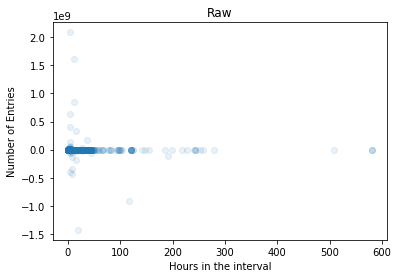

In [14]:
interval_in_hours = sorted_data.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, sorted_data.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')

(-3000, 5000)

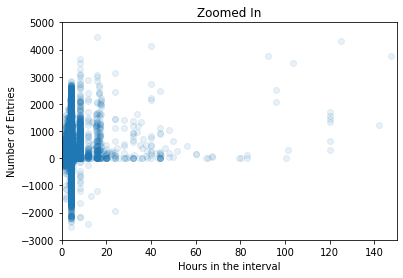

In [15]:
plt.scatter(interval_in_hours, sorted_data.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Zoomed In')
plt.xlim([0,150])
plt.ylim([-3000, 5000])

Conclusion: high entries values are not due to long time intervals for counting

In [16]:
sorted_data.time_interval.quantile(0.999).total_seconds() / 3600

8.0

In [17]:
sorted_data.entries_since_last_record.quantile(0.999)

1913.0

In [18]:
sorted_data.entries_since_last_record.quantile(0.0091)

-1.0

Conclusion: Could remove all intervals above 8 hrs, all negative entries values, and all entries values above 1913 and still only remove ~1.1% of the data set

## 2.5 Calculate Outliers Within A Turnstile

In [19]:
sorted_data['unit_mean'] = sorted_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['entries_since_last_record'].transform('mean')

In [20]:
sorted_data['unit_std'] = sorted_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['entries_since_last_record'].transform('std')

In [21]:
sorted_data['deviations'] = (sorted_data['entries_since_last_record'] - sorted_data['unit_mean']) / sorted_data['unit_std']


In [22]:
sorted_data.describe([0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

,ENTRIES,entries_since_last_record,time_interval,unit_mean,unit_std,deviations
count,1016285.000,1011402.000,1011402,1016271.000,1016265.000,960222.000
mean,40529956.499,2066.048,0 days 03:59:39.541903,2064.916,151249.407,0.000
std,208311278.270,3421941.072,0 days 01:36:09.342946,234270.500,3418951.384,0.998
min,0.000,-1428035580.000,0 days 00:00:00,-7069372.589,0.000,-14.933
0.01%,0.000,-1791052.851,0 days 00:00:08,-7069372.589,0.000,-13.711
0.1%,0.000,-825.000,0 days 00:01:20,-642517.976,0.000,-1.785
1%,0.000,0.000,0 days 01:20:56,-9349.700,0.000,-1.351
10%,18391.000,0.000,0 days 04:00:00,0.048,0.951,-0.991
50%,2285667.000,68.000,0 days 04:00:00,137.986,143.202,-0.186
90%,15417265.600,479.000,0 days 04:00:00,364.577,380.190,1.428


## 2.6 Remove Within Unit Outliers

In [23]:
no_unit_outliers = sorted_data[((sorted_data.deviations > -5) & (sorted_data.deviations < 5)) | sorted_data.deviations.isna()]

In [24]:
no_unit_outliers.shape[0] / sorted_data.shape[0]

0.9990711267016634

## 2.7 Visualize Without Unit Outliers

Text(0.5, 1.0, 'Raw')

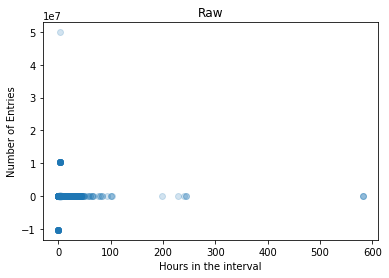

In [25]:
interval_in_hours = no_unit_outliers.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, no_unit_outliers.entries_since_last_record, alpha=0.2)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')


In [26]:
no_unit_outliers.describe([0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

,ENTRIES,entries_since_last_record,time_interval,unit_mean,unit_std,deviations
count,1015341.000,1010458.000,1010458,1015327.000,1015321.000,959278.000
mean,40537504.316,217.006,0 days 03:59:14.722463,2058.965,150540.900,-0.004
std,208328233.072,82970.949,0 days 01:16:05.855198,233812.099,3411897.994,0.955
min,0.000,-10314855.000,0 days 00:00:00,-7069372.589,0.000,-4.948
0.01%,0.000,-1658.954,0 days 00:00:18,-7069372.589,0.000,-2.750
0.1%,0.000,-727.000,0 days 00:01:20,-642517.976,0.000,-1.665
1%,0.000,0.000,0 days 01:20:59,-9349.700,0.000,-1.349
10%,18646.000,0.000,0 days 04:00:00,0.048,0.968,-0.991
50%,2290987.000,68.000,0 days 04:00:00,138.129,143.222,-0.187
90%,15416988.000,478.000,0 days 04:00:00,364.577,380.190,1.420


## 2.8 Remove Extreme Entries Outliers

In [27]:
no_extreme_outliers = no_unit_outliers[
    (no_unit_outliers.entries_since_last_record < no_unit_outliers.entries_since_last_record.quantile(0.99995)) & 
    (no_unit_outliers.entries_since_last_record > no_unit_outliers.entries_since_last_record.quantile(0.00005))]

Text(0.5, 1.0, 'Raw')

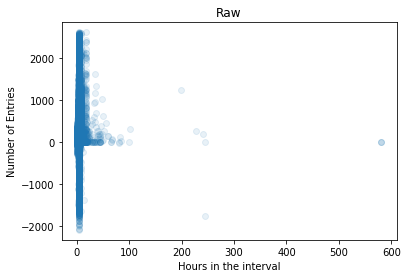

In [28]:
interval_in_hours = no_extreme_outliers.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, no_extreme_outliers.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')

## 2.9 Remove Extreme Interval Outliers

In [29]:
no_extreme_outliers.describe([0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

,ENTRIES,entries_since_last_record,time_interval,unit_mean,unit_std,deviations
count,1010356.000,1010356.000,1010356,1010356.000,1010353.000,959176.000
mean,40529168.748,167.707,0 days 03:59:13.490501,2044.986,150125.708,-0.004
std,208302536.217,257.439,0 days 01:15:26.454563,233540.788,3408202.641,0.955
min,0.000,-2092.000,0 days 00:00:00,-7069372.589,0.000,-4.530
0.01%,0.000,-1505.929,0 days 00:00:31,-7069372.589,0.000,-2.689
0.1%,0.000,-706.645,0 days 00:01:20,-642517.976,0.000,-1.652
1%,0.000,0.000,0 days 01:21:15,-9349.700,0.000,-1.349
10%,18664.000,0.000,0 days 04:00:00,0.048,0.968,-0.991
50%,2290595.000,68.000,0 days 04:00:00,138.129,143.222,-0.187
90%,15413273.500,478.000,0 days 04:00:00,364.577,379.898,1.419


In [30]:
no_extreme_interval_outliers = no_extreme_outliers[no_extreme_outliers.time_interval < no_extreme_outliers.time_interval.quantile(0.99995)]

In [31]:
no_extreme_interval_outliers.shape[0] / no_extreme_outliers.shape[0]

0.9999495227424788

Text(0.5, 1.0, 'Raw')

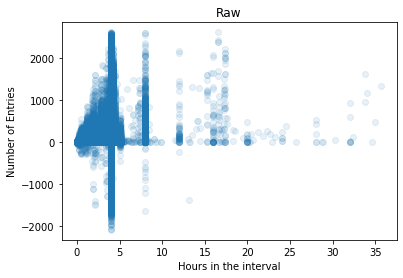

In [32]:
interval_in_hours = no_extreme_interval_outliers.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, no_extreme_interval_outliers.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')

In [33]:
# Status - the percent we've removed thus far
1 - (no_extreme_interval_outliers.shape[0] / mta_data.shape[0])

0.005884176190733892

## 2.10 Investigate Negatives

In [34]:
no_extreme_interval_outliers['always_decreasing'] = no_extreme_interval_outliers.groupby(['C/A', 'UNIT', 'SCP', 'STATION']).transform(lambda s: s.is_monotonic_decreasing)['ENTRIES']


/Users/sidisu/opt/miniconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
always_decreasing = no_extreme_interval_outliers[
    (no_extreme_interval_outliers.entries_since_last_record < 0) &
    no_extreme_interval_outliers.always_decreasing &
    no_extreme_interval_outliers.unit_mean != 0
]

In [36]:
always_decreasing.describe([0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

,ENTRIES,entries_since_last_record,time_interval,unit_mean,unit_std,deviations
count,8607.000,8607.000,8607,8607.000,8607.000,8607.000
mean,1198984225.002,-294.060,0 days 03:57:03.137911,-290.659,269.349,-0.031
std,661311811.510,331.913,0 days 00:29:02.202133,156.279,140.238,0.996
min,8695.000,-2092.000,0 days 00:00:56,-660.356,0.591,-4.530
0.01%,8976.416,-2082.533,0 days 00:01:14.933200,-660.356,0.591,-4.530
0.1%,10617.356,-1884.970,0 days 00:01:20,-660.356,0.591,-3.487
1%,25203.800,-1537.940,0 days 00:31:36.320000,-660.356,43.866,-2.711
10%,98304563.000,-715.400,0 days 04:00:00,-549.857,83.564,-1.566
50%,1291172679.000,-186.000,0 days 04:00:00,-279.582,262.773,0.218
90%,1942995409.400,-14.000,0 days 04:00:00,-84.701,492.438,1.007


Text(0.5, 1.0, 'Raw')

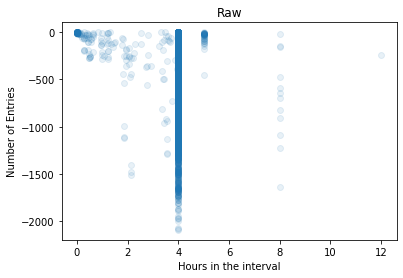

In [37]:
interval_in_hours = always_decreasing.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, always_decreasing.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')

In [38]:
always_decreasing.shape[0] / no_extreme_interval_outliers[no_extreme_interval_outliers.entries_since_last_record < 0].shape[0]

0.9518911745189117

95% of negative values are in turnstiles that are always decreasing

## 2.11 Flip Reasonable Negatives

In [39]:
copy = no_extreme_interval_outliers.copy()

In [40]:
always_decreasing.entries_since_last_record.quantile(0.01)

-1537.94

In [41]:
copy['corrected_entries_since_last_record'] = np.where(
    (
        (copy.entries_since_last_record < 0) &
        copy.always_decreasing &
        copy.unit_mean != 0 &
        (copy.entries_since_last_record > always_decreasing.entries_since_last_record.quantile(0.01))
    ),
    np.abs(copy.entries_since_last_record),
    copy.entries_since_last_record
)

## 2.12 Drop Remaining Negatives

In [42]:
cleaned = copy[copy.corrected_entries_since_last_record >= 0]

In [43]:
cleaned.shape[0] / mta_data.shape[0]

0.9936877942703081

We removed 0.7% of the data

Text(0.5, 1.0, 'Cleaned')

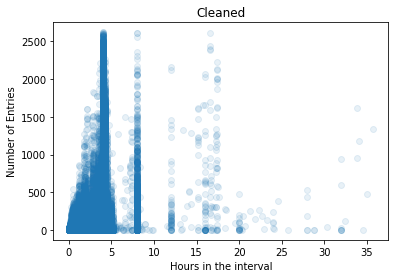

In [44]:
interval_in_hours = cleaned.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, cleaned.corrected_entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Cleaned')

## 2.13 Select Relevant Columns

In [45]:
relevant = cleaned[['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'datetime', 'corrected_entries_since_last_record', 'time_interval']]
                   

In [46]:
relevant = relevant.rename(columns={'corrected_entries_since_last_record': 'entries'})

In [47]:
relevant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1009870 entries, 1 to 204594
Data columns (total 9 columns):
C/A              1009870 non-null object
UNIT             1009870 non-null object
SCP              1009870 non-null object
STATION          1009870 non-null object
DATE             1009870 non-null datetime64[ns]
TIME             1009870 non-null object
datetime         1009870 non-null datetime64[ns]
entries          1009870 non-null float64
time_interval    1009870 non-null timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), object(5), timedelta64[ns](1)
memory usage: 77.0+ MB


In [48]:
relevant.head()

,C/A,UNIT,SCP,STATION,DATE,TIME,datetime,entries,time_interval
1,A002,R051,02-00-00,59 ST,2019-02-23,07:00:00,2019-02-23 07:00:00,11.000,04:00:00
2,A002,R051,02-00-00,59 ST,2019-02-23,11:00:00,2019-02-23 11:00:00,60.000,04:00:00
3,A002,R051,02-00-00,59 ST,2019-02-23,15:00:00,2019-02-23 15:00:00,160.000,04:00:00
4,A002,R051,02-00-00,59 ST,2019-02-23,19:00:00,2019-02-23 19:00:00,290.000,04:00:00
5,A002,R051,02-00-00,59 ST,2019-02-23,23:00:00,2019-02-23 23:00:00,143.000,04:00:00


# 3. Store Data

In [49]:
with open('cleaned_mta_data_march.pickle', 'wb') as write_file:
    pickle.dump(relevant, write_file)

# 4. Adjust Intervals That Cross Days

## 4.1 Explore Intervals 

In [50]:
counts = relevant.TIME.value_counts()
counts.head(20)

04:00:00    76541
08:00:00    76492
20:00:00    76428
16:00:00    76403
12:00:00    76385
00:00:00    73916
11:00:00    37790
07:00:00    37784
23:00:00    37764
15:00:00    37737
19:00:00    37703
09:00:00    37650
05:00:00    37650
21:00:00    37610
17:00:00    37605
13:00:00    37573
01:00:00    35824
03:00:00    35308
14:00:00     2820
22:00:00     2817
Name: TIME, dtype: int64

In [51]:
relevant.iloc[0].TIME

datetime.time(7, 0)

In [52]:
relevant[relevant.TIME == datetime.time(0, 0)]

,C/A,UNIT,SCP,STATION,DATE,TIME,datetime,entries,time_interval
11,A002,R051,02-00-00,59 ST,2019-03-11,00:00:00,2019-03-11,80.000,04:00:00
17,A002,R051,02-00-00,59 ST,2019-03-12,00:00:00,2019-03-12,175.000,04:00:00
23,A002,R051,02-00-00,59 ST,2019-03-13,00:00:00,2019-03-13,229.000,04:00:00
32,A002,R051,02-00-00,59 ST,2019-03-14,00:00:00,2019-03-14,217.000,04:00:00
39,A002,R051,02-00-00,59 ST,2019-03-15,00:00:00,2019-03-15,249.000,04:00:00
...,...,...,...,...,...,...,...,...,...
203968,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-03-06,00:00:00,2019-03-06,0.000,04:00:00
203974,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-03-07,00:00:00,2019-03-07,0.000,04:00:00
203981,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-03-08,00:00:00,2019-03-08,0.000,04:00:00
201750,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-03-09,00:00:00,2019-03-09,0.000,04:00:00


In [53]:
import datetime

d1 = pd.to_datetime('1/2/2019 03:00')
d2 = d1 - pd.Timedelta('4 hours')

In [54]:
d1.day

2

In [55]:
d2.day

1

In [56]:
td = pd.Timedelta('4 hours')
td.total_seconds() / 3600

4.0

In [57]:
pd.to_datetime('1/2/2019 03:00').hour

3

In [58]:
more_than_one_day = relevant[relevant.datetime.dt.hour < (relevant.time_interval.dt.total_seconds() / 3600)]

more_than_one_day.shape[0] / relevant.shape[0]

0.16440333904363927

16% of the records are overlapping a day

In [59]:
and_at_midnight = more_than_one_day[more_than_one_day.TIME == datetime.time(0, 0)]
and_at_midnight.shape[0] / more_than_one_day.shape[0]

0.44520737715779457

Of that 16%, almost half of them are at midnight

In [60]:
(relevant[relevant.time_interval.dt.total_seconds() >= (24 * 3600)].shape[0] / relevant.shape[0]) * 100

0.0028716567478982444

Less than 0.001% of the records are larger than 1 day. Perhaps remove

Plan Below:

In [61]:
# remove records with intervals >= 24 hours
# add a starting datetime field
    # start_datetime = datetime - time_interval
    # rename datetime -> 'end_datetime'
# drop DATE, TIME
# replace all datetime values of 00:00 with 23:59 of the prev day
 
# if starting_datetime and end_datetime are on different days
    # insert tomorrow's record:
        # station values: same
        # start_datetime: 00:00
        # end_datetime: end_datetime from record
        # entries: proportional
        # time_interval: end_datetime - start_datetime
    # ajust values:
        # entries: proportion of interval on the starting day
        # end_datetime: 23:59
        # time_interval: end_datetime - start_datetime
        

## 4.2 Clean Datetime Fields

In [62]:
less_than_24 = relevant[relevant.time_interval < pd.Timedelta('24 hours')].copy()

In [63]:
less_than_24['start_datetime'] = less_than_24.datetime - less_than_24.time_interval

In [64]:
less_than_24 = less_than_24.rename(columns={ 'datetime': 'end_datetime'})

In [65]:
less_than_24 = less_than_24.drop(columns=['DATE', 'TIME'])

In [66]:
less_than_24['end_datetime'] = np.where(
    less_than_24.end_datetime.dt.hour == 0,
    less_than_24.end_datetime - pd.Timedelta('1 second'),
    less_than_24.end_datetime
)

## 4.3 Split Entries That Overlap Days

### 4.3.1 Append Records for Next Day's Entries

In [67]:
less_than_24.head()

,C/A,UNIT,SCP,STATION,end_datetime,entries,time_interval,start_datetime
1,A002,R051,02-00-00,59 ST,2019-02-23 07:00:00,11.000,04:00:00,2019-02-23 03:00:00
2,A002,R051,02-00-00,59 ST,2019-02-23 11:00:00,60.000,04:00:00,2019-02-23 07:00:00
3,A002,R051,02-00-00,59 ST,2019-02-23 15:00:00,160.000,04:00:00,2019-02-23 11:00:00
4,A002,R051,02-00-00,59 ST,2019-02-23 19:00:00,290.000,04:00:00,2019-02-23 15:00:00
5,A002,R051,02-00-00,59 ST,2019-02-23 23:00:00,143.000,04:00:00,2019-02-23 19:00:00


In [68]:
def set_datetime_to_midnight(date):
    return date.replace(hour=0, minute=0, second=0)

In [69]:
new_records = less_than_24[less_than_24.start_datetime.dt.day != less_than_24.end_datetime.dt.day].copy()
new_records['new_start_datetime'] = new_records.end_datetime.map(set_datetime_to_midnight)
new_records['interval_on_that_day'] = new_records.end_datetime - new_records.new_start_datetime

In [70]:
new_records['proportional_entries'] = new_records.entries * (new_records.interval_on_that_day / new_records.time_interval)

In [71]:
new_records['entries'] = new_records['proportional_entries']
new_records['time_interval'] = new_records['interval_on_that_day']
new_records['start_datetime'] = new_records['new_start_datetime']
records_to_add = new_records[['C/A','UNIT','SCP','STATION','end_datetime','entries','time_interval','start_datetime']]

In [72]:
with_split = less_than_24.append(records_to_add)

### 4.3.2 Reset Records With Only Today's Value

In [73]:
with_split['new_end_datetime'] = np.where(
    with_split.start_datetime.dt.day != with_split.end_datetime.dt.day,
    with_split.end_datetime.map(lambda date: (date - pd.Timedelta('1 day')).replace(hour=23, minute=59, second=59)),
    with_split.end_datetime
)

In [74]:
with_split[with_split.end_datetime != with_split.new_end_datetime].new_end_datetime.unique()

array(['2019-02-23T23:59:59.000000000', '2019-02-24T23:59:59.000000000',
       '2019-02-25T23:59:59.000000000', '2019-02-26T23:59:59.000000000',
       '2019-02-27T23:59:59.000000000', '2019-02-28T23:59:59.000000000',
       '2019-03-01T23:59:59.000000000', '2019-03-02T23:59:59.000000000',
       '2019-03-03T23:59:59.000000000', '2019-03-04T23:59:59.000000000',
       '2019-03-05T23:59:59.000000000', '2019-03-06T23:59:59.000000000',
       '2019-03-07T23:59:59.000000000', '2019-03-08T23:59:59.000000000',
       '2019-03-09T23:59:59.000000000', '2019-03-10T23:59:59.000000000',
       '2019-03-11T23:59:59.000000000', '2019-03-12T23:59:59.000000000',
       '2019-03-13T23:59:59.000000000', '2019-03-14T23:59:59.000000000',
       '2019-03-15T23:59:59.000000000', '2019-03-16T23:59:59.000000000',
       '2019-03-17T23:59:59.000000000', '2019-03-18T23:59:59.000000000',
       '2019-03-19T23:59:59.000000000', '2019-03-20T23:59:59.000000000',
       '2019-03-21T23:59:59.000000000', '2019-03-22

In [75]:
with_split['interval_on_that_day'] = with_split.new_end_datetime - with_split.start_datetime

In [76]:
with_split['adjusted_entries'] = np.where(
    with_split.start_datetime.dt.day != with_split.end_datetime.dt.day,
    with_split.entries * (with_split.interval_on_that_day / with_split.time_interval),
    with_split.entries
)

/Users/sidisu/opt/miniconda3/envs/metis/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py:597: RuntimeWarning: invalid value encountered in true_divide
  return other / self._data


In [77]:
with_split[with_split.entries != with_split.adjusted_entries].sample(10)

,C/A,UNIT,SCP,STATION,end_datetime,entries,time_interval,start_datetime,new_end_datetime,interval_on_that_day,adjusted_entries
131438,R116,R030,00-06-01,CHAMBERS ST,2019-03-07 03:00:00,24.000,04:00:00,2019-03-06 23:00:00,2019-03-06 23:59:59,00:59:59,5.998
124846,R101,R001,02-00-08,SOUTH FERRY,2019-03-12 01:00:00,55.000,04:00:00,2019-03-11 21:00:00,2019-03-11 23:59:59,02:59:59,41.246
135899,R151,R033,00-00-00,TIMES SQ-42 ST,2019-03-10 04:00:00,39.000,05:00:00,2019-03-09 23:00:00,2019-03-09 23:59:59,00:59:59,7.798
66296,N124,R103,00-00-02,BROADWAY JCT,2019-03-03 03:00:00,39.000,04:00:00,2019-03-02 23:00:00,2019-03-02 23:59:59,00:59:59,9.747
173760,R335,R444,00-00-00,NEREID AV,2019-03-18 01:00:00,36.000,04:00:00,2019-03-17 21:00:00,2019-03-17 23:59:59,02:59:59,26.997
66786,N138,R355,01-06-01,111 ST,2019-03-15 01:00:00,5.000,04:00:00,2019-03-14 21:00:00,2019-03-14 23:59:59,02:59:59,3.750
65265,N123B,R439,01-06-01,ROCKAWAY AV,2019-03-19 01:00:00,50.000,04:00:00,2019-03-18 21:00:00,2019-03-18 23:59:59,02:59:59,37.497
101573,N530,R301,00-00-01,YORK ST,2019-03-18 01:00:00,143.000,04:00:00,2019-03-17 21:00:00,2019-03-17 23:59:59,02:59:59,107.240
13626,B010,R412,00-00-00,BOTANIC GARDEN,2019-03-18 01:00:00,24.000,04:00:00,2019-03-17 21:00:00,2019-03-17 23:59:59,02:59:59,17.998
48275,N044,R187,00-03-02,81 ST-MUSEUM,2019-03-24 01:00:00,83.000,04:00:00,2019-03-23 21:00:00,2019-03-23 23:59:59,02:59:59,62.244


In [78]:
with_split[with_split.start_datetime.dt.day != with_split.new_end_datetime.dt.day]

,C/A,UNIT,SCP,STATION,end_datetime,entries,time_interval,start_datetime,new_end_datetime,interval_on_that_day,adjusted_entries


In [79]:
clean_columns = with_split[['C/A', 'UNIT', 'SCP', 'STATION', 'start_datetime', 'new_end_datetime', 'interval_on_that_day', 'adjusted_entries']]

In [80]:
clean_columns = clean_columns.rename(columns={ 'new_end_datetime': 'end_datetime', 'adjusted_entries': 'entries' })


In [81]:
clean_columns.sample(10)

,C/A,UNIT,SCP,STATION,start_datetime,end_datetime,interval_on_that_day,entries
18106,B026,R230,00-06-00,NECK RD,2019-03-20 20:00:00,2019-03-20 23:59:59,03:59:59,38.000
188135,R532,R328,00-00-03,METS-WILLETS PT,2019-03-06 08:00:00,2019-03-06 12:00:00,04:00:00,150.000
33893,H027,R137,01-06-00,MYRTLE-WYCKOFF,2019-03-08 19:00:00,2019-03-08 23:00:00,04:00:00,207.000
194077,R606,R225,00-00-00,HOYT ST,2019-03-27 00:00:00,2019-03-27 04:00:00,04:00:00,20.000
189966,R534,R055,01-03-05,FLUSHING-MAIN,2019-03-01 15:00:00,2019-03-01 19:00:00,04:00:00,273.000
19841,C004,R089,01-06-00,JAY ST-METROTEC,2019-03-16 20:00:00,2019-03-16 23:59:59,03:59:59,16.000
82819,N330,R202,00-03-02,63 DR-REGO PARK,2019-03-13 08:00:00,2019-03-13 12:00:00,04:00:00,99.000
2810,A021,R032,01-00-02,TIMES SQ-42 ST,2019-03-22 12:00:00,2019-03-22 16:00:00,04:00:00,299.000
172481,R325,R388,00-05-00,E 180 ST,2019-02-26 00:00:00,2019-02-26 04:00:00,04:00:00,0.000
134513,R142,R293,01-06-01,34 ST-PENN STA,2019-03-12 14:00:00,2019-03-12 18:00:00,04:00:00,211.000


### 4.3.3 Validation

In [82]:
num_in_less_than_24 = less_than_24.shape[0]
num_across_days = less_than_24[less_than_24.start_datetime.dt.day != less_than_24.end_datetime.dt.day].shape[0]
num_in_clean_cols = clean_columns.shape[0]

num_in_clean_cols == (num_in_less_than_24 + num_across_days)

True

In [83]:
clean_columns[clean_columns.start_datetime.dt.day != clean_columns.end_datetime.dt.day].shape[0]

0

In [84]:
clean_columns.shape[0] / mta_data.shape[0]

1.0821472323216421

## 4.4 Store Data

In [85]:
with open('super_cleaned_mta_data_march.pickle', 'wb') as write_file:
    pickle.dump(clean_columns, write_file)

In [86]:
clean_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1099770 entries, 1 to 204589
Data columns (total 8 columns):
C/A                     1099770 non-null object
UNIT                    1099770 non-null object
SCP                     1099770 non-null object
STATION                 1099770 non-null object
start_datetime          1099770 non-null datetime64[ns]
end_datetime            1099770 non-null datetime64[ns]
interval_on_that_day    1099770 non-null timedelta64[ns]
entries                 1099770 non-null float64
dtypes: datetime64[ns](2), float64(1), object(4), timedelta64[ns](1)
memory usage: 75.5+ MB


# Explore

In [96]:
#res = clean_columns.groupby(['C/A', 'UNIT', 'SCP', 'STATION', clean_columns.start_datetime.dt.strftime('%m/%d/%y')]).agg({ 'entries': 'sum'})

In [109]:
clean_columns_tim = clean_columns.copy()
clean_columns_tim.head()

,C/A,UNIT,SCP,STATION,start_datetime,end_datetime,interval_on_that_day,entries
1,A002,R051,02-00-00,59 ST,2019-02-23 03:00:00,2019-02-23 07:00:00,04:00:00,11.000
2,A002,R051,02-00-00,59 ST,2019-02-23 07:00:00,2019-02-23 11:00:00,04:00:00,60.000
3,A002,R051,02-00-00,59 ST,2019-02-23 11:00:00,2019-02-23 15:00:00,04:00:00,160.000
4,A002,R051,02-00-00,59 ST,2019-02-23 15:00:00,2019-02-23 19:00:00,04:00:00,290.000
5,A002,R051,02-00-00,59 ST,2019-02-23 19:00:00,2019-02-23 23:00:00,04:00:00,143.000


In [320]:
#df_mta['ACTUALDAY_edit'] = pd.to_datetime(df_mta['DATE']).apply(lambda x: x.strftime('%m%d%Y'))

# adding column with only date so we can group by date later
clean_columns_tim['date_edit'] = pd.to_datetime(clean_columns_tim['start_datetime'].apply(lambda x: x.strftime('%m/%d/%y')))

# adding weekday vs. weekend categorization so we can group later
def weekday_vs_weekend(day_int):
    if day_int in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']:
        return 'Weekday'
    elif day_int in ['Saturday', 'Sunday']:
        return 'Weekend'

clean_columns_tim['day_of_week'] = clean_columns_tim['start_datetime'].dt.day_name().apply(lambda x: weekday_vs_weekend(x))

# ask John why doesnt below work... where does .dt go vs. .datetime; whats the natural language behind these
#clean_columns_tim['day_of_week'] = weekday_vs_weekend(clean_columns_tim['start_datetime'].dt.day_name()) 2* df['column']

#apply(lambda x: weekday_vs_weekend(x.weekday()))))

In [426]:
clean_columns_tim.head(50)

,C/A,UNIT,SCP,STATION,start_datetime,end_datetime,interval_on_that_day,entries,date_edit,day_of_week
1,A002,R051,02-00-00,59 ST,2019-02-23 03:00:00,2019-02-23 07:00:00,04:00:00,11.000,2019-02-23,Weekend
2,A002,R051,02-00-00,59 ST,2019-02-23 07:00:00,2019-02-23 11:00:00,04:00:00,60.000,2019-02-23,Weekend
3,A002,R051,02-00-00,59 ST,2019-02-23 11:00:00,2019-02-23 15:00:00,04:00:00,160.000,2019-02-23,Weekend
4,A002,R051,02-00-00,59 ST,2019-02-23 15:00:00,2019-02-23 19:00:00,04:00:00,290.000,2019-02-23,Weekend
5,A002,R051,02-00-00,59 ST,2019-02-23 19:00:00,2019-02-23 23:00:00,04:00:00,143.000,2019-02-23,Weekend
6,A002,R051,02-00-00,59 ST,2019-02-23 23:00:00,2019-02-23 23:59:59,00:59:59,7.498,2019-02-23,Weekend
7,A002,R051,02-00-00,59 ST,2019-02-24 03:00:00,2019-02-24 07:00:00,04:00:00,7.000,2019-02-24,Weekend
8,A002,R051,02-00-00,59 ST,2019-02-24 07:00:00,2019-02-24 11:00:00,04:00:00,31.000,2019-02-24,Weekend
9,A002,R051,02-00-00,59 ST,2019-02-24 11:00:00,2019-02-24 15:00:00,04:00:00,100.000,2019-02-24,Weekend
10,A002,R051,02-00-00,59 ST,2019-02-24 15:00:00,2019-02-24 19:00:00,04:00:00,157.000,2019-02-24,Weekend


In [401]:
# ask John why copy is not working
weekdays_analysis = clean_columns_tim.groupby(['STATION', 'day_of_week'], as_index=False).agg({'start_datetime': 'count', 'entries': 'sum'}).copy()
#weekdays_analysis = clean_columns_tim.groupby(['STATION', 'day_of_week'], as_index=False).agg({'start_datetime': 'size', 'entries': 'sum'})

In [403]:
weekdays_analysis.head()

,STATION,day_of_week,start_datetime,entries
0,1 AV,Weekday,1609,496698.154
1,1 AV,Weekend,640,23234.723
2,103 ST,Weekday,2452,767642.309
3,103 ST,Weekend,946,154625.776
4,103 ST-CORONA,Weekday,1449,503205.816


In [404]:
weekdays_analysis = weekdays_analysis.rename(columns={"start_datetime": "count_of_days_in_data"})

In [182]:
#weekdays_analysis['count_of_days_in_data'] = pd.to_numeric(weekdays_analysis['count_of_days_in_data'])

In [405]:
weekdays_analysis['entries_per_day'] = weekdays_analysis['entries'] / weekdays_analysis['count_of_days_in_data'] 

In [406]:
weekdays_analysis

,STATION,day_of_week,count_of_days_in_data,entries,entries_per_day
0,1 AV,Weekday,1609,496698.154,308.700
1,1 AV,Weekend,640,23234.723,36.304
2,103 ST,Weekday,2452,767642.309,313.068
3,103 ST,Weekend,946,154625.776,163.452
4,103 ST-CORONA,Weekday,1449,503205.816,347.278
...,...,...,...,...,...
751,WTC-CORTLANDT,Weekend,2236,61923.857,27.694
752,YORK ST,Weekday,522,306643.667,587.440
753,YORK ST,Weekend,192,53432.328,278.293
754,ZEREGA AV,Weekday,983,68441.181,69.625


In [269]:
# get number of highest entry stations
stations_from_tyler = ['34 ST-PENN STA',
 'GRD CNTRL-42 ST',
 '34 ST-HERALD SQ',
 '23 ST',
 '42 ST-PORT AUTH',
 '14 ST-UNION SQ',
 'TIMES SQ-42 ST',
 'FULTON ST',
 '86 ST',
 '125 ST',
 'CANAL ST',
 '59 ST COLUMBUS',
 '59 ST',
 '14 ST',
 '96 ST',
 'CHAMBERS ST',
 'FLUSHING-MAIN',
 '47-50 STS ROCK',
 'JKSN HT-ROOSVLT',
 '50 ST']

# use filter to identify the set of stations we want to pull
#df.loc[df.gender == 'Male', ]
stations_to_graph = weekdays_analysis.loc[(weekdays_analysis['STATION'].isin(list(stations_from_tyler)))]

# separate series for weekday vs. weekend - while making sure to sort by station so both output series are tied
#df[df.age > 50].head(4)
stations_to_graph_weekday = stations_to_graph[stations_to_graph.day_of_week == 'Weekday'].sort_values(['STATION'])['entries_per_day']
stations_to_graph_weekend = stations_to_graph[stations_to_graph.day_of_week == 'Weekend'].sort_values(['STATION'])['entries_per_day']

In [270]:
stations_to_graph.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 18 to 705
Data columns (total 5 columns):
STATION                  40 non-null object
day_of_week              40 non-null object
count_of_days_in_data    40 non-null int64
entries                  40 non-null float64
entries_per_day          40 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.9+ KB


In [271]:
# check it pulled in the stations

len(stations_to_graph['STATION'].unique())

20

['125 ST', '14 ST', '14 ST-UNION SQ', '23 ST', '34 ST-HERALD SQ', '34 ST-PENN STA', '42 ST-PORT AUTH', '47-50 STS ROCK', '50 ST', '59 ST', '59 ST COLUMBUS', '86 ST', '96 ST', 'CANAL ST', 'CHAMBERS ST', 'FLUSHING-MAIN', 'FULTON ST', 'GRD CNTRL-42 ST', 'JKSN HT-ROOSVLT', 'TIMES SQ-42 ST']


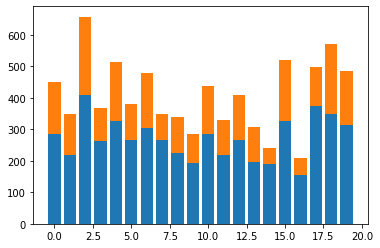

In [256]:
"""N = 5
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width, yerr=menStd)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans, yerr=womenStd)"""

N = len(stations_to_graph_weekday)
ind = np.arange(N)
width = 0.35

p1 = plt.bar(ind, stations_to_graph_weekday)
p2 = plt.bar(ind, stations_to_graph_weekend,bottom=stations_to_graph_weekday.values)
print(sorted(stations_from_tyler))

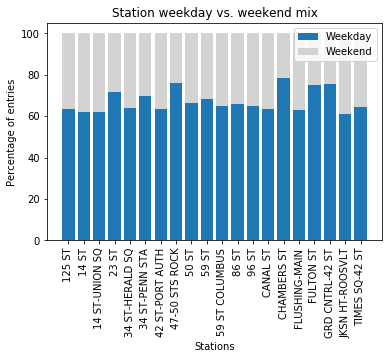

In [314]:
"""
# Data
r = [0,1,2,3,4]
raw_data = {'greenBars': [20, 1.5, 7, 10, 5], 'orangeBars': [5, 15, 5, 10, 15],'blueBars': [2, 15, 18, 5, 10]}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['greenBars'], df['orangeBars'], df['blueBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]
blueBars = [i / j * 100 for i,j in zip(df['blueBars'], totals)]
 
# plot
barWidth = 0.85
names = ('A','B','C','D','E')
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth)
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth)
# Create blue Bars
plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth)
 
# Custom x axis
plt.xticks(r, names)
plt.xlabel("group")
 
# Show graphic
plt.show()
"""

# Custom x axis settings
N = len(stations_to_graph_weekday)
ind = np.arange(N)
width = 0.35
names = sorted(stations_from_tyler)
plt.xticks(ind, names, rotation=90)
plt.xlabel('Stations')
plt.ylabel('Percentage of entries')
plt.title('Station weekday vs. weekend mix')

# from raw entries per day values to percentage
totals = [i+j for i,j in zip(stations_to_graph_weekday, stations_to_graph_weekend)]
blueBars = [(i / j) * 100 for i,j in zip(stations_to_graph_weekday, totals)]
orangeBars = [(i / j) * 100 for i,j in zip(stations_to_graph_weekend, totals)]

# plot
p1 = plt.bar(ind, blueBars, color='tab:blue', label = 'Weekday')
p2 = plt.bar(ind, orangeBars,bottom=blueBars, color = 'lightgray', label = 'Weekend')
plt.legend(loc="upper right")

# Show graphic
plt.rcParams.update({'font.size': 20})
plt.show()


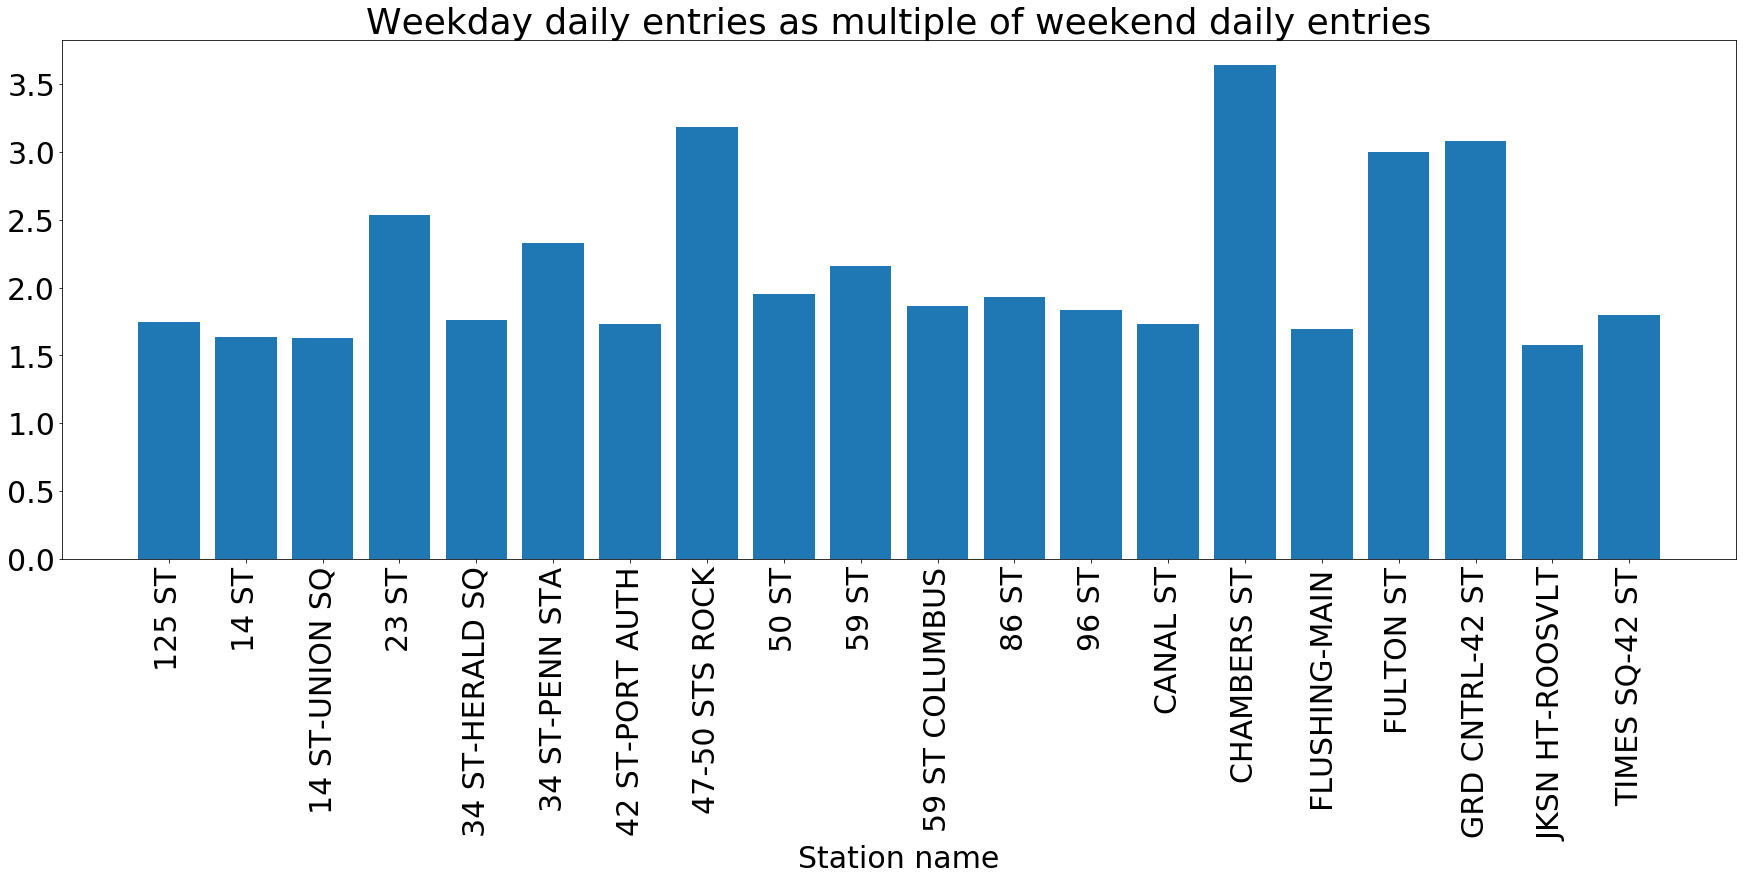

In [375]:
"""
# Data
r = [0,1,2,3,4]
raw_data = {'greenBars': [20, 1.5, 7, 10, 5], 'orangeBars': [5, 15, 5, 10, 15],'blueBars': [2, 15, 18, 5, 10]}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['greenBars'], df['orangeBars'], df['blueBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]
blueBars = [i / j * 100 for i,j in zip(df['blueBars'], totals)]
 
# plot
barWidth = 0.85
names = ('A','B','C','D','E')
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth)
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth)
# Create blue Bars
plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth)
 
# Custom x axis
plt.xticks(r, names)
plt.xlabel("group")
 
# Show graphic
plt.show()
"""

# Custom x axis settings
plt.figure(figsize = [30,15]) # [width, height]
N = len(stations_to_graph_weekday)
ind = np.arange(N)
width = 0.35
names = sorted(stations_from_tyler)
plt.xticks(ind, names, rotation=90)
plt.xlabel('Station name')
plt.title('Weekday daily entries as multiple of weekend daily entries')


# from raw entries per day values to percentage
#totals = [i+j for i,j in zip(stations_to_graph_weekday, stations_to_graph_weekend)] #old code when doing 100% stack
blueBars = [(i / j) for i,j in zip(stations_to_graph_weekday, stations_to_graph_weekend)]
#orangeBars = [(i / j) * 100 for i,j in zip(stations_to_graph_weekend, totals)] #old code when doing 100% stack

# plot
p1 = plt.bar(ind, blueBars, color='tab:blue', label = 'Weekday')
#p2 = plt.bar(ind, orangeBars,bottom=blueBars, color = 'lightgray', label = 'Weekend')
#plt.legend(loc="upper right")


# Show graphic
plt.rcParams.update({'font.size': 20})
plt.gcf().subplots_adjust(bottom=0.4)
plt.show

# Save plot as jpb
plt.savefig('weekdays_analysis.png', format='png')



In [385]:
data_for_willy = [(i / j) for i,j in zip(stations_to_graph_weekday, stations_to_graph_weekend)]
data_for_willy = zip(sorted(stations_from_tyler), data_for_willy)

In [386]:
pd.DataFrame(data_for_willy)

,0,1
0,125 ST,1.749
1,14 ST,1.639
2,14 ST-UNION SQ,1.630
3,23 ST,2.536
4,34 ST-HERALD SQ,1.761
5,34 ST-PENN STA,2.328
6,42 ST-PORT AUTH,1.735
7,47-50 STS ROCK,3.186
8,50 ST,1.955
9,59 ST,2.159


In [412]:
weekdays_analysis_temp = weekdays_analysis.loc[weekdays_analysis['day_of_week'] == 'Weekday']

In [421]:
weekdays_analysis_temp = weekdays_analysis_temp.sort_values('entries_per_day', ascending=False)

In [424]:
weekdays_analysis_temp['entries_per_day'].iloc[4:24].mean()

349.0902929115231

In [418]:
weekdays_analysis_temp['entries_per_day'].iloc[24:].mean()

174.66301776524853

In [425]:
weekdays_analysis

,STATION,day_of_week,count_of_days_in_data,entries,entries_per_day
0,1 AV,Weekday,1609,496698.154,308.700
1,1 AV,Weekend,640,23234.723,36.304
2,103 ST,Weekday,2452,767642.309,313.068
3,103 ST,Weekend,946,154625.776,163.452
4,103 ST-CORONA,Weekday,1449,503205.816,347.278
...,...,...,...,...,...
751,WTC-CORTLANDT,Weekend,2236,61923.857,27.694
752,YORK ST,Weekday,522,306643.667,587.440
753,YORK ST,Weekend,192,53432.328,278.293
754,ZEREGA AV,Weekday,983,68441.181,69.625
